In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:
!pip3 install jupyterthemes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchsummary import summary
import torch_xla
import torch_xla.core.xla_model as xm
import os
import sys
from datetime import datetime
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.Resize((64, 64))
])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root="./DATA/", transform=transform, 
                                          download=True)

In [ ]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [ ]:
def get_discriminator_block(input_channel, output_channel, kernel_size=3, stride=2, 
                            padding=0, final_layer=False, batchNorm=True):
    """
    Function to build the discriminator neural network layer
    
    Parameters : 
    @param input_dim -- a python integer representing the input channel
    @param output_dim -- a python integer representing the output channel
    @param kernel_size -- a python integer representing the kernel size (by default=3)
    @param stride -- a python integer representing the stride value (by default=2)
    @param final_layer -- a boolean value representing whether it is the final layer
    
    Return :
    disc_block -- a discriminator neural block
    """
    disc_block = None
    if not final_layer and batchNorm:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    elif not final_layer and not batchNorm:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        
    else:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
        )
        
    return disc_block
        
        

In [ ]:
def get_generator_block(input_channel, output_channel, kernel_size=3, 
                        stride=2, padding=0, final_layer=False):
    
    """
    Function to build the generator block 
    
    Parameters:
    @param input_channel -- a python integer representing the number of input channels
    @param output_channel -- a python integer representing the number of output channels
    @param kernel_size -- a python integer representing the kernel_size (by default=3)
    @param stride -- a python integer representing the stride value (by default=2)
    @param final_layer -- a boolean value indicating if it's for the final layer
    
    Return :
    gen_block -- a generator neural block
    """
    gen_block = None
    if not final_layer:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
        
    else:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding,bias=False),
            nn.Tanh()
        )
        
    return gen_block

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, input_channels, hidden_dim=64):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            get_discriminator_block(input_channels, hidden_dim, kernel_size=4, padding=1, batchNorm=False),
            get_discriminator_block(hidden_dim, hidden_dim*2, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*2, hidden_dim*4, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*4, hidden_dim*8, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*8, 1, kernel_size=4, stride = 1, padding=0, final_layer=True)
        )
        
    def forward(self, image):
        return self.disc(image)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim, im_channels=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.gen = nn.Sequential(
            get_generator_block(latent_dim, hidden_dim*8, kernel_size=4, stride=1),
            get_generator_block(hidden_dim*8, hidden_dim*4, kernel_size=4, padding=1),
            get_generator_block(hidden_dim*4, hidden_dim*2, kernel_size=4, padding=1),
            get_generator_block(hidden_dim*2, hidden_dim, kernel_size=4, padding=1),
            get_generator_block(hidden_dim, im_channels, kernel_size=4, padding=1, final_layer=True)
        )
        
    def unsqueeze_noise(self, noise):
        """
        Reshapes the noise into height of 1 and width of 1 
        and number of channels = latent_dim
        """
        return noise.view(len(noise), self.latent_dim, 1, 1)
    
    def forward(self, noise):
        noise = self.unsqueeze_noise(noise)
        return self.gen(noise)

In [ ]:
def get_noise(batch_size, latent_dim, device):
    """
    Function to generate noise from Normal Distribution
    
    Parameters:
    @param batch_size -- the batch size
    @param latent_dim -- the latent dimension of the noise
    
    Return:
    @ret noise -- the noise vector
    """
    noise = torch.randn(batch_size, latent_dim, device=device)
    return noise

In [ ]:
def get_discriminator_loss(G, D, criterion, real_data, latent_dim, 
                          batch_size, device):
    """
    Function to compute the discriminator loss
    
    Parameters:
    @param G -- the Generator Network
    @param D -- the Discriminator Network
    @param criterion -- the loss function 
    @param real_data -- the authentic data 
    @param latent_dim -- the dimension to create noise
    @param batch_size -- the batch size 
    @param device -- the device to use (cpu/cuda)
    
    Return:
    @ret disc_loss -- the discriminator loss
    """
    
    real_pred = D(real_data)
    ones_ = torch.ones_like(real_pred).to(device)
    d_real_loss = criterion(real_pred, ones_)
    
    noise = get_noise(batch_size, latent_dim, device)
    fake_data = G(noise).detach()
    fake_pred = D(fake_data)
    zeros_ = torch.zeros_like(fake_pred)
    d_fake_loss = criterion(fake_pred, zeros_)
    
    disc_loss = 0.5 * (d_real_loss + d_fake_loss)
    
    return disc_loss
    

In [ ]:
def get_generator_loss(G, D, criterion, latent_dim, batch_size, device):
    """
    Function to calculate the generator loss
    
    Parameters:
    @param G -- the Generator Network
    @param D -- the Discriminator Network
    @param criterion -- the Loss function
    @param latent_dim -- the latent dimension of the noise
    @param batch_size -- a python integer representing the batch size
    @param device -- the device whether it is cpu or cuda
    
    Return :
    gen_loss -- the Generator loss
    """
    
    noise = get_noise(batch_size, latent_dim, device)
    fake_data = G(noise)
    fake_pred = D(fake_data)
    ones_ = torch.ones_like(fake_pred)
    gen_loss = criterion(fake_pred, ones_)
    return gen_loss

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = xm.xla_device()
print(f"Device used : {device}")

Device used : xla:1


In [ ]:
latent_dim = 100
G = Generator(latent_dim)
D = Discriminator(3)

In [ ]:
summary(G, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(D, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
---------------------------

In [ ]:
G = G.to(device)
D = D.to(device)

g_optim = torch.optim.Adam(G.parameters(), lr=1e-4*4, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=1e-4*2, betas=(0.5, 0.999))

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.normal_(m.bias, mean=0)

In [ ]:
G = G.apply(init_weights)
D = D.apply(init_weights)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
if not os.path.exists("./IMAGES/DCGANs_CIFAR/"):
    os.mkdir("./IMAGES/DCGANs_CIFAR/")

In [ ]:
def train(data_iter, G, D, criterion, g_optim, d_optim, latent_dim, 
          epochs=200, save=True, device=device):
    
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        t0 = datetime.now()
        d_loss = []
        g_loss = []
        batch_size = 0
        
        for inputs, _ in tqdm(data_iter):
            
            inputs = inputs.to(device)
            
            batch_size = inputs.size(0)
            
            ###################################
            ##### TRAIN DISCRIMINATOR ######
            ##################################
            
            d_optim.zero_grad()
            dLoss = get_discriminator_loss(G, D, criterion, inputs, 
                                           latent_dim, batch_size, device)
            
            dLoss.backward()
            # d_optim.step()
            xm.optimizer_step(d_optim, barrier=True)
            
            d_loss.append(dLoss.item())
            
            ###################################
            ########## TRAIN GENERATOR #######
            ##################################
            # gLoss = []
            # for _ in  range(2):
            g_optim.zero_grad()
            gLoss = get_generator_loss(G, D, criterion, latent_dim, batch_size, device)
            gLoss.backward()
                # g_optim.step()
            xm.optimizer_step(g_optim, barrier=True)

                # gLoss.append(_gLoss.item())
            g_loss.append(gLoss.item())

            # g_loss.append(np.mean(gLoss))
            
            
        d_loss = np.mean(d_loss)
        g_loss = np.mean(g_loss)
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        print(f"Epoch : {epoch+1}/{epochs} || Disc Loss : {d_loss} || Gen Loss: {g_loss} || Computation Time : {datetime.now() - t0}")
        
        if save and epoch % 10 == 0:
            noise = get_noise(batch_size, latent_dim, device)
            fake_img = G(noise)
            save_image(fake_img, f"./IMAGES/DCGANs_CIFAR/gan-{epoch+1}.png", normalize=True)
    
    return g_losses, d_losses

In [ ]:
g_losses, d_losses = train(train_iter, G, D, criterion, g_optim, d_optim, 
                           latent_dim)


Epoch : 1/200 || Disc Loss : 0.4150195188458313 || Gen Loss: 1.605064383060064 || Computation Time : 0:01:21.123006



Epoch : 2/200 || Disc Loss : 0.4096142437280444 || Gen Loss: 1.955402971562141 || Computation Time : 0:01:14.141369



Epoch : 3/200 || Disc Loss : 0.2937066965996076 || Gen Loss: 2.808804930866603 || Computation Time : 0:01:13.257190



Epoch : 4/200 || Disc Loss : 0.26610434834685776 || Gen Loss: 3.2182708661574537 || Computation Time : 0:01:13.301558



Epoch : 5/200 || Disc Loss : 0.3646595037882895 || Gen Loss: 2.618182773556551 || Computation Time : 0:01:14.120889



Epoch : 6/200 || Disc Loss : 0.4263381599389074 || Gen Loss: 2.0224285956729404 || Computation Time : 0:01:13.780192



Epoch : 7/200 || Disc Loss : 0.4476326235458064 || Gen Loss: 1.8674243835498914 || Computation Time : 0:01:14.691642



Epoch : 8/200 || Disc Loss : 0.4756213866383828 || Gen Loss: 1.788088633123871 || Computation Time : 0:01:13.710688



Epoch : 9/200 || Disc Loss : 0.4482569881069386 || Gen Loss: 1.9479894915886242 || Computation Time : 0:01:13.680035



Epoch : 10/200 || Disc Loss : 0.4155273007281372 || Gen Loss: 2.128033027910363 || Computation Time : 0:01:13.660561



Epoch : 11/200 || Disc Loss : 0.36215304115506086 || Gen Loss: 2.257699147209792 || Computation Time : 0:01:13.976451



Epoch : 12/200 || Disc Loss : 0.3061958909382486 || Gen Loss: 2.567758576549075 || Computation Time : 0:01:13.494945



Epoch : 13/200 || Disc Loss : 0.17702649948794558 || Gen Loss: 3.565940881867314 || Computation Time : 0:01:13.549444



Epoch : 14/200 || Disc Loss : 0.2290120958981802 || Gen Loss: 3.099877267270861 || Computation Time : 0:01:13.737511



Epoch : 15/200 || Disc Loss : 0.352107558704322 || Gen Loss: 2.5578185317560296 || Computation Time : 0:01:14.807933



Epoch : 16/200 || Disc Loss : 0.23441606374752835 || Gen Loss: 3.1043472097271962 || Computation Time : 0:01:13.400844



Epoch : 17/200 || Disc Loss : 0.318406907989241 || Gen Loss: 3.032272355994708 || Computation Time : 0:01:13.480109



Epoch : 18/200 || Disc Loss : 0.14149534805139521 || Gen Loss: 4.262525056000523 || Computation Time : 0:01:13.982389



Epoch : 19/200 || Disc Loss : 0.2611530985292571 || Gen Loss: 3.0281518982947255 || Computation Time : 0:01:14.064751



Epoch : 20/200 || Disc Loss : 0.3244311179789474 || Gen Loss: 2.7560631726913707 || Computation Time : 0:01:13.394633



Epoch : 21/200 || Disc Loss : 0.2827992487074736 || Gen Loss: 3.0855663128201956 || Computation Time : 0:01:13.541526



Epoch : 22/200 || Disc Loss : 0.18786354889840726 || Gen Loss: 3.4982648607780513 || Computation Time : 0:01:13.645339



Epoch : 23/200 || Disc Loss : 0.291481636931448 || Gen Loss: 3.157058742442188 || Computation Time : 0:01:14.494307



Epoch : 24/200 || Disc Loss : 0.26663600216450556 || Gen Loss: 3.166655281662943 || Computation Time : 0:01:13.371670



Epoch : 25/200 || Disc Loss : 0.2246344875016719 || Gen Loss: 3.7472943625186006 || Computation Time : 0:01:13.389152



Epoch : 26/200 || Disc Loss : 0.2584366465173185 || Gen Loss: 3.1441783101376517 || Computation Time : 0:01:14.090595



Epoch : 27/200 || Disc Loss : 0.3178250170634378 || Gen Loss: 2.795678724144178 || Computation Time : 0:01:13.575782



Epoch : 28/200 || Disc Loss : 0.2748577157297479 || Gen Loss: 3.259405058185128 || Computation Time : 0:01:14.102939



Epoch : 29/200 || Disc Loss : 0.33863594610829983 || Gen Loss: 2.6076580761286343 || Computation Time : 0:01:13.578619



Epoch : 30/200 || Disc Loss : 0.25341710208288737 || Gen Loss: 3.387182561885518 || Computation Time : 0:01:14.012505



Epoch : 31/200 || Disc Loss : 0.3632780785429413 || Gen Loss: 2.545762966183619 || Computation Time : 0:01:13.512405



Epoch : 32/200 || Disc Loss : 0.2980952041599985 || Gen Loss: 3.1255302261129434 || Computation Time : 0:01:14.526672



Epoch : 33/200 || Disc Loss : 0.2254195757471668 || Gen Loss: 3.754487507234421 || Computation Time : 0:01:13.340916



Epoch : 34/200 || Disc Loss : 0.3020574160568092 || Gen Loss: 2.8179772343400797 || Computation Time : 0:01:13.638140



Epoch : 35/200 || Disc Loss : 0.30271978352857215 || Gen Loss: 3.1388074773721577 || Computation Time : 0:01:13.441531



Epoch : 36/200 || Disc Loss : 0.17230252545628258 || Gen Loss: 4.247471419970066 || Computation Time : 0:01:13.872237



Epoch : 37/200 || Disc Loss : 0.3152650472472238 || Gen Loss: 2.8030898739950603 || Computation Time : 0:01:13.552515



Epoch : 38/200 || Disc Loss : 0.16722465520772292 || Gen Loss: 4.295652513976207 || Computation Time : 0:01:14.071711



Epoch : 39/200 || Disc Loss : 0.2886959206660652 || Gen Loss: 3.1767116580587214 || Computation Time : 0:01:14.080610



Epoch : 40/200 || Disc Loss : 0.26898977273236724 || Gen Loss: 3.2870502894520377 || Computation Time : 0:01:15.245501



Epoch : 41/200 || Disc Loss : 0.2855047011182851 || Gen Loss: 3.1404687938952507 || Computation Time : 0:01:13.863417



Epoch : 42/200 || Disc Loss : 0.28022673579237767 || Gen Loss: 3.210404768881961 || Computation Time : 0:01:13.521252



Epoch : 43/200 || Disc Loss : 0.2573902862139947 || Gen Loss: 3.4412771211127224 || Computation Time : 0:01:13.734995



Epoch : 44/200 || Disc Loss : 0.2921676430053285 || Gen Loss: 3.0670013427076075 || Computation Time : 0:01:13.797846



Epoch : 45/200 || Disc Loss : 0.2691884006473624 || Gen Loss: 3.2726846202478317 || Computation Time : 0:01:13.588467



Epoch : 46/200 || Disc Loss : 0.2719528657286559 || Gen Loss: 3.351293377060493 || Computation Time : 0:01:13.192763



Epoch : 47/200 || Disc Loss : 0.2728859587427219 || Gen Loss: 3.1829867356294477 || Computation Time : 0:01:13.999567



Epoch : 48/200 || Disc Loss : 0.21361181037583868 || Gen Loss: 3.681490168694759 || Computation Time : 0:01:15.195706



Epoch : 49/200 || Disc Loss : 0.05190377232253604 || Gen Loss: 6.431002296313171 || Computation Time : 0:01:14.347449



Epoch : 50/200 || Disc Loss : 0.20824938328446024 || Gen Loss: 3.0140420533811954 || Computation Time : 0:01:13.865460



Epoch : 51/200 || Disc Loss : 0.2533779629646703 || Gen Loss: 3.13107987403479 || Computation Time : 0:01:14.285128



Epoch : 52/200 || Disc Loss : 0.2784807136129883 || Gen Loss: 3.0359741429270657 || Computation Time : 0:01:13.535695



Epoch : 53/200 || Disc Loss : 0.2911915722758035 || Gen Loss: 3.1036138541773473 || Computation Time : 0:01:14.266312



Epoch : 54/200 || Disc Loss : 0.26982432503141274 || Gen Loss: 3.3410338200810004 || Computation Time : 0:01:14.046657



Epoch : 55/200 || Disc Loss : 0.2994610966847795 || Gen Loss: 3.0445593160263678 || Computation Time : 0:01:14.257367



Epoch : 56/200 || Disc Loss : 0.2979486037469695 || Gen Loss: 3.163046031767295 || Computation Time : 0:01:14.800206



Epoch : 57/200 || Disc Loss : 0.279251232371687 || Gen Loss: 3.167091813476761 || Computation Time : 0:01:14.301746



Epoch : 58/200 || Disc Loss : 0.2976720581602905 || Gen Loss: 2.872657187761652 || Computation Time : 0:01:13.697804



Epoch : 59/200 || Disc Loss : 0.2932822472830315 || Gen Loss: 3.1029704393690354 || Computation Time : 0:01:14.189940



Epoch : 60/200 || Disc Loss : 0.23860606559030617 || Gen Loss: 3.4982469706603174 || Computation Time : 0:01:13.891742



Epoch : 61/200 || Disc Loss : 0.28052387456111894 || Gen Loss: 3.3860120093318993 || Computation Time : 0:01:14.079495



Epoch : 62/200 || Disc Loss : 0.22813228288498086 || Gen Loss: 3.750955589763496 || Computation Time : 0:01:13.731930



Epoch : 63/200 || Disc Loss : 0.1726245175757686 || Gen Loss: 4.29450392623585 || Computation Time : 0:01:14.261393



Epoch : 64/200 || Disc Loss : 0.2818091808010817 || Gen Loss: 3.1479673801452073 || Computation Time : 0:01:14.036782



Epoch : 65/200 || Disc Loss : 0.2755765239219836 || Gen Loss: 3.0079360301695677 || Computation Time : 0:01:15.019498



Epoch : 66/200 || Disc Loss : 0.20653604822548324 || Gen Loss: 3.9698441666823365 || Computation Time : 0:01:14.243753



Epoch : 67/200 || Disc Loss : 0.2863752228562789 || Gen Loss: 3.0088695226924913 || Computation Time : 0:01:14.611456



Epoch : 68/200 || Disc Loss : 0.32804580715239584 || Gen Loss: 2.950423819453517 || Computation Time : 0:01:14.713549



Epoch : 69/200 || Disc Loss : 0.2384823334595079 || Gen Loss: 3.714871877166794 || Computation Time : 0:01:13.992021



Epoch : 70/200 || Disc Loss : 0.20512940403362237 || Gen Loss: 3.6156808616560134 || Computation Time : 0:01:14.310634



Epoch : 71/200 || Disc Loss : 0.2587344703595618 || Gen Loss: 3.4160465056405385 || Computation Time : 0:01:14.138836



Epoch : 72/200 || Disc Loss : 0.227141057086937 || Gen Loss: 3.6394472941363234 || Computation Time : 0:01:14.300485



Epoch : 73/200 || Disc Loss : 0.3285837863510013 || Gen Loss: 3.013544576262049 || Computation Time : 0:01:14.652295



Epoch : 74/200 || Disc Loss : 0.14588753382682496 || Gen Loss: 4.312259991257869 || Computation Time : 0:01:14.162133



Epoch : 75/200 || Disc Loss : 0.29153198440847417 || Gen Loss: 2.8541610831837825 || Computation Time : 0:01:13.553694



Epoch : 76/200 || Disc Loss : 0.22532792360988704 || Gen Loss: 3.5933723020441164 || Computation Time : 0:01:13.732436



Epoch : 77/200 || Disc Loss : 0.19807939125966909 || Gen Loss: 3.927584430195696 || Computation Time : 0:01:13.334796



Epoch : 78/200 || Disc Loss : 0.36238832756653044 || Gen Loss: 2.4535209697032885 || Computation Time : 0:01:13.574988



Epoch : 79/200 || Disc Loss : 0.2954784483729821 || Gen Loss: 3.145946796042407 || Computation Time : 0:01:13.014726



Epoch : 80/200 || Disc Loss : 0.27429008437886293 || Gen Loss: 3.2634659936208554 || Computation Time : 0:01:12.783836



Epoch : 81/200 || Disc Loss : 0.21475278326254243 || Gen Loss: 3.8191967653938335 || Computation Time : 0:01:13.389778



Epoch : 82/200 || Disc Loss : 0.24243832714474567 || Gen Loss: 3.6275318010888524 || Computation Time : 0:01:13.015581



Epoch : 83/200 || Disc Loss : 0.22608836193460627 || Gen Loss: 3.763680263932156 || Computation Time : 0:01:13.194554



Epoch : 84/200 || Disc Loss : 0.3027713029095165 || Gen Loss: 3.0502781022772782 || Computation Time : 0:01:13.245184



Epoch : 85/200 || Disc Loss : 0.29410006999945665 || Gen Loss: 3.108031523985072 || Computation Time : 0:01:13.031975



Epoch : 86/200 || Disc Loss : 0.2813371531653416 || Gen Loss: 3.031363401738236 || Computation Time : 0:01:13.061156



Epoch : 87/200 || Disc Loss : 0.23919399886879156 || Gen Loss: 3.679927702369097 || Computation Time : 0:01:13.220905



Epoch : 88/200 || Disc Loss : 0.23894729031740553 || Gen Loss: 3.3345094067578063 || Computation Time : 0:01:13.184201



Epoch : 89/200 || Disc Loss : 0.2952715896708352 || Gen Loss: 3.2024889001265513 || Computation Time : 0:01:13.476823



Epoch : 90/200 || Disc Loss : 0.23847331740754082 || Gen Loss: 3.565903157699848 || Computation Time : 0:01:12.459617



Epoch : 91/200 || Disc Loss : 0.2471567608589959 || Gen Loss: 3.1598389755429515 || Computation Time : 0:01:12.827244



Epoch : 92/200 || Disc Loss : 0.2834677302223199 || Gen Loss: 3.170184434439196 || Computation Time : 0:01:12.672982



Epoch : 93/200 || Disc Loss : 0.30776068028014947 || Gen Loss: 3.1026314451075097 || Computation Time : 0:01:12.804077



Epoch : 94/200 || Disc Loss : 0.23193567788973926 || Gen Loss: 3.4722903074529627 || Computation Time : 0:01:12.541627



Epoch : 95/200 || Disc Loss : 0.16480351813093466 || Gen Loss: 4.302104379576761 || Computation Time : 0:01:13.336009



Epoch : 96/200 || Disc Loss : 0.21519646464514752 || Gen Loss: 3.9591308867652923 || Computation Time : 0:01:25.104444



Epoch : 97/200 || Disc Loss : 0.28724793383322866 || Gen Loss: 3.1397371202175233 || Computation Time : 0:01:12.762868



Epoch : 98/200 || Disc Loss : 0.2557818526878496 || Gen Loss: 3.274781026847689 || Computation Time : 0:01:13.411541



Epoch : 99/200 || Disc Loss : 0.20262271900306386 || Gen Loss: 3.9292147697071234 || Computation Time : 0:01:12.603968



Epoch : 100/200 || Disc Loss : 0.27366542691946066 || Gen Loss: 3.2728432507602983 || Computation Time : 0:01:12.177090



Epoch : 101/200 || Disc Loss : 0.23731127413807918 || Gen Loss: 3.6705580216995024 || Computation Time : 0:01:12.420573



Epoch : 102/200 || Disc Loss : 0.2155415794792492 || Gen Loss: 3.89537300275388 || Computation Time : 0:01:16.084923



Epoch : 103/200 || Disc Loss : 0.20150011777639618 || Gen Loss: 4.171188173413067 || Computation Time : 0:01:12.980760



Epoch : 104/200 || Disc Loss : 0.22727115000562403 || Gen Loss: 3.0318657290678748 || Computation Time : 0:01:12.933153



Epoch : 105/200 || Disc Loss : 0.20613745321332694 || Gen Loss: 3.9528402148447026 || Computation Time : 0:01:12.859903



Epoch : 106/200 || Disc Loss : 0.25074755703367035 || Gen Loss: 3.512302281430267 || Computation Time : 0:01:13.722916



Epoch : 107/200 || Disc Loss : 0.24242579321081623 || Gen Loss: 3.7412294757326836 || Computation Time : 0:01:12.899584



Epoch : 108/200 || Disc Loss : 0.2909996183779653 || Gen Loss: 2.9559623700997713 || Computation Time : 0:01:13.114529



Epoch : 109/200 || Disc Loss : 0.24543180862320182 || Gen Loss: 3.5212199752761424 || Computation Time : 0:01:12.946452



Epoch : 110/200 || Disc Loss : 0.20814139960194364 || Gen Loss: 3.74264605644559 || Computation Time : 0:01:12.705265



Epoch : 111/200 || Disc Loss : 0.23331582335674245 || Gen Loss: 3.526239324172916 || Computation Time : 0:01:12.496385



Epoch : 112/200 || Disc Loss : 0.28165421968616566 || Gen Loss: 3.2098991987229204 || Computation Time : 0:01:13.067338



Epoch : 113/200 || Disc Loss : 0.22453051195313198 || Gen Loss: 3.431450223392995 || Computation Time : 0:01:13.713875



Epoch : 114/200 || Disc Loss : 0.25836235490660936 || Gen Loss: 3.1785817091684323 || Computation Time : 0:01:13.621011



Epoch : 115/200 || Disc Loss : 0.2325473210448042 || Gen Loss: 3.7777409604071734 || Computation Time : 0:01:13.062618



Epoch : 116/200 || Disc Loss : 0.21624945902862275 || Gen Loss: 3.5806641658921246 || Computation Time : 0:01:13.285776



Epoch : 117/200 || Disc Loss : 0.24979866419078026 || Gen Loss: 3.484353329123193 || Computation Time : 0:01:13.213415



Epoch : 118/200 || Disc Loss : 0.20426583597007805 || Gen Loss: 3.6486236394079024 || Computation Time : 0:01:13.271225



Epoch : 119/200 || Disc Loss : 0.29086353105452395 || Gen Loss: 3.30894788038319 || Computation Time : 0:01:13.014916



Epoch : 120/200 || Disc Loss : 0.1949146464389637 || Gen Loss: 3.957191858593079 || Computation Time : 0:01:13.287041



Epoch : 121/200 || Disc Loss : 0.2666049547227876 || Gen Loss: 3.7736103762810878 || Computation Time : 0:01:13.257788



Epoch : 122/200 || Disc Loss : 0.26519996239958554 || Gen Loss: 3.3524196223208116 || Computation Time : 0:01:13.132765



Epoch : 123/200 || Disc Loss : 0.13693835319179443 || Gen Loss: 4.417343860373015 || Computation Time : 0:01:14.074004



Epoch : 124/200 || Disc Loss : 0.21966791849540512 || Gen Loss: 3.4846632723956157 || Computation Time : 0:01:12.966140



Epoch : 125/200 || Disc Loss : 0.2495678387251218 || Gen Loss: 3.3829792668838135 || Computation Time : 0:01:13.190081



Epoch : 126/200 || Disc Loss : 0.26788366151868803 || Gen Loss: 3.2831191097595083 || Computation Time : 0:01:13.158661



Epoch : 127/200 || Disc Loss : 0.28262007982431986 || Gen Loss: 3.103231706283689 || Computation Time : 0:01:12.705025



Epoch : 128/200 || Disc Loss : 0.30628466823012057 || Gen Loss: 2.9668172610009 || Computation Time : 0:01:12.859755



Epoch : 129/200 || Disc Loss : 0.23366283784058337 || Gen Loss: 3.6652666848400592 || Computation Time : 0:01:13.127961



Epoch : 130/200 || Disc Loss : 0.22666612008566875 || Gen Loss: 3.6604065696442087 || Computation Time : 0:01:12.881316



Epoch : 131/200 || Disc Loss : 0.2538505029743132 || Gen Loss: 3.4690147503672164 || Computation Time : 0:01:13.515882



Epoch : 132/200 || Disc Loss : 0.25438747709900467 || Gen Loss: 3.3403673945542645 || Computation Time : 0:01:12.882301



Epoch : 133/200 || Disc Loss : 0.17477525204724972 || Gen Loss: 4.065283100575666 || Computation Time : 0:01:12.871623



Epoch : 134/200 || Disc Loss : 0.187174009427171 || Gen Loss: 4.347876481719057 || Computation Time : 0:01:12.766054



Epoch : 135/200 || Disc Loss : 0.24471591542596402 || Gen Loss: 3.4493237067840163 || Computation Time : 0:01:12.738461



Epoch : 136/200 || Disc Loss : 0.23108915864166035 || Gen Loss: 3.455715151913071 || Computation Time : 0:01:12.783619



Epoch : 137/200 || Disc Loss : 0.2750362095136024 || Gen Loss: 3.3970753820934583 || Computation Time : 0:01:12.809047



Epoch : 138/200 || Disc Loss : 0.16849882479714196 || Gen Loss: 4.257695401330357 || Computation Time : 0:01:12.924740



Epoch : 139/200 || Disc Loss : 0.22350857171076385 || Gen Loss: 3.960270398725162 || Computation Time : 0:01:13.527214



Epoch : 140/200 || Disc Loss : 0.1943266219483293 || Gen Loss: 3.865282609360096 || Computation Time : 0:01:12.670503



Epoch : 141/200 || Disc Loss : 0.1540213095883498 || Gen Loss: 4.726360456417258 || Computation Time : 0:01:12.507454



Epoch : 142/200 || Disc Loss : 0.26238709925542897 || Gen Loss: 3.2866549922876556 || Computation Time : 0:01:12.540903



Epoch : 143/200 || Disc Loss : 0.24799919968990186 || Gen Loss: 3.647096281513036 || Computation Time : 0:01:12.285571



Epoch : 144/200 || Disc Loss : 0.21618584976793573 || Gen Loss: 4.010440869731745 || Computation Time : 0:01:11.865770



Epoch : 145/200 || Disc Loss : 0.059031606919582945 || Gen Loss: 5.3713063149500995 || Computation Time : 0:01:12.097680



Epoch : 146/200 || Disc Loss : 0.24705015831981855 || Gen Loss: 3.128294892511243 || Computation Time : 0:01:12.329269



Epoch : 147/200 || Disc Loss : 0.17316557742480207 || Gen Loss: 4.21777551247287 || Computation Time : 0:01:12.169679



Epoch : 148/200 || Disc Loss : 0.26872640667016356 || Gen Loss: 3.1366596337493577 || Computation Time : 0:01:13.370673



Epoch : 149/200 || Disc Loss : 0.11481784064086901 || Gen Loss: 4.962762824046072 || Computation Time : 0:01:12.094345



Epoch : 150/200 || Disc Loss : 0.25564146909447116 || Gen Loss: 3.4993486674228387 || Computation Time : 0:01:12.328776



Epoch : 151/200 || Disc Loss : 0.2461185862186372 || Gen Loss: 3.508309465063506 || Computation Time : 0:01:12.538336



Epoch : 152/200 || Disc Loss : 0.18616953633411232 || Gen Loss: 4.15913122694867 || Computation Time : 0:01:12.408716



Epoch : 153/200 || Disc Loss : 0.2530853993228406 || Gen Loss: 3.1824909987409318 || Computation Time : 0:01:12.166469



Epoch : 154/200 || Disc Loss : 0.2565431359562958 || Gen Loss: 3.656327308412784 || Computation Time : 0:01:12.283771



Epoch : 155/200 || Disc Loss : 0.25973378243091544 || Gen Loss: 3.239303568821124 || Computation Time : 0:01:13.173639



Epoch : 156/200 || Disc Loss : 0.20590565457929383 || Gen Loss: 4.19391619904246 || Computation Time : 0:01:12.610708



Epoch : 157/200 || Disc Loss : 0.22798645427055142 || Gen Loss: 3.455515596967209 || Computation Time : 0:01:12.472730



Epoch : 158/200 || Disc Loss : 0.22646672849539223 || Gen Loss: 3.79239599914421 || Computation Time : 0:01:11.967888



Epoch : 159/200 || Disc Loss : 0.21288775483026023 || Gen Loss: 3.9611002577687886 || Computation Time : 0:01:12.286212



Epoch : 160/200 || Disc Loss : 0.11052571266488817 || Gen Loss: 5.1182959831014365 || Computation Time : 0:01:12.175566



Epoch : 161/200 || Disc Loss : 0.2350606334364742 || Gen Loss: 3.2681582892120664 || Computation Time : 0:01:12.048008



Epoch : 162/200 || Disc Loss : 0.23997196764149287 || Gen Loss: 3.7824002876853964 || Computation Time : 0:01:12.089332



Epoch : 163/200 || Disc Loss : 0.16196618139598806 || Gen Loss: 4.32747713785188 || Computation Time : 0:01:12.758149



Epoch : 164/200 || Disc Loss : 0.1414769231999779 || Gen Loss: 4.048522298463651 || Computation Time : 0:01:12.864006



Epoch : 165/200 || Disc Loss : 0.275377805554963 || Gen Loss: 3.4207795522011133 || Computation Time : 0:01:13.221811



Epoch : 166/200 || Disc Loss : 0.26505217987381857 || Gen Loss: 3.250730133929845 || Computation Time : 0:01:12.199278



Epoch : 167/200 || Disc Loss : 0.23932656366080332 || Gen Loss: 3.092603398263073 || Computation Time : 0:01:12.271419



Epoch : 168/200 || Disc Loss : 0.17324497898215252 || Gen Loss: 4.498906163674986 || Computation Time : 0:01:12.629194



Epoch : 169/200 || Disc Loss : 0.1936110538347741 || Gen Loss: 3.6923094441089424 || Computation Time : 0:01:12.274582



Epoch : 170/200 || Disc Loss : 0.3065119566273211 || Gen Loss: 3.197186424099462 || Computation Time : 0:01:12.359152



Epoch : 171/200 || Disc Loss : 0.2800079275558576 || Gen Loss: 3.0890283847292523 || Computation Time : 0:01:12.156687



Epoch : 172/200 || Disc Loss : 0.2378436199465619 || Gen Loss: 3.425014795163823 || Computation Time : 0:01:12.670349



Epoch : 173/200 || Disc Loss : 0.24680118301533202 || Gen Loss: 3.4023058386158547 || Computation Time : 0:01:12.770367



Epoch : 174/200 || Disc Loss : 0.09542334582933518 || Gen Loss: 5.003553967646626 || Computation Time : 0:01:12.071541



Epoch : 175/200 || Disc Loss : 0.20646997579924828 || Gen Loss: 3.82833511283206 || Computation Time : 0:01:12.020572



Epoch : 176/200 || Disc Loss : 0.15293306806940546 || Gen Loss: 4.44987247127026 || Computation Time : 0:01:12.508784



Epoch : 177/200 || Disc Loss : 0.16033802113761944 || Gen Loss: 4.403488748925788 || Computation Time : 0:01:12.474865



Epoch : 178/200 || Disc Loss : 0.13835800325621844 || Gen Loss: 4.326676106018484 || Computation Time : 0:01:12.300293



Epoch : 179/200 || Disc Loss : 0.22061552450148975 || Gen Loss: 3.622718369013846 || Computation Time : 0:01:12.159783



Epoch : 180/200 || Disc Loss : 0.13614378552205023 || Gen Loss: 4.488591214754473 || Computation Time : 0:01:12.456670



Epoch : 181/200 || Disc Loss : 0.16770160173320825 || Gen Loss: 4.541649589208094 || Computation Time : 0:01:13.314873



Epoch : 182/200 || Disc Loss : 0.22282853258042443 || Gen Loss: 3.420908953746795 || Computation Time : 0:01:12.125606



Epoch : 183/200 || Disc Loss : 0.22048675789125025 || Gen Loss: 3.9481865050592857 || Computation Time : 0:01:12.294155



Epoch : 184/200 || Disc Loss : 0.15110342455250772 || Gen Loss: 4.4078734335549115 || Computation Time : 0:01:12.933777



Epoch : 185/200 || Disc Loss : 0.14106828364221466 || Gen Loss: 4.663502931609289 || Computation Time : 0:01:13.917170



Epoch : 186/200 || Disc Loss : 0.22858312899214656 || Gen Loss: 3.7123984677339226 || Computation Time : 0:01:12.946029



Epoch : 187/200 || Disc Loss : 0.17524565020671395 || Gen Loss: 3.916121117337166 || Computation Time : 0:01:12.814711



Epoch : 188/200 || Disc Loss : 0.1812450335655228 || Gen Loss: 4.460002469942462 || Computation Time : 0:01:13.456464



Epoch : 189/200 || Disc Loss : 0.15038954914973862 || Gen Loss: 4.635380808425986 || Computation Time : 0:01:13.492093



Epoch : 190/200 || Disc Loss : 0.26005705482686114 || Gen Loss: 2.9992358323351582 || Computation Time : 0:01:13.524299



Epoch : 191/200 || Disc Loss : 0.13313424549779504 || Gen Loss: 4.43155805132817 || Computation Time : 0:01:13.027274



Epoch : 192/200 || Disc Loss : 0.17505911074768124 || Gen Loss: 4.270332741729446 || Computation Time : 0:01:12.786292



Epoch : 193/200 || Disc Loss : 0.21787543041164728 || Gen Loss: 3.561810723632155 || Computation Time : 0:01:13.781128



Epoch : 194/200 || Disc Loss : 0.18427576675184568 || Gen Loss: 4.135875845343754 || Computation Time : 0:01:12.941660



Epoch : 195/200 || Disc Loss : 0.12769098079610317 || Gen Loss: 4.486509929184833 || Computation Time : 0:01:12.986025



Epoch : 196/200 || Disc Loss : 0.1929079415312375 || Gen Loss: 3.6387318132666735 || Computation Time : 0:01:13.253578



Epoch : 197/200 || Disc Loss : 0.23320232668374677 || Gen Loss: 3.6260280121201234 || Computation Time : 0:01:13.187873



Epoch : 198/200 || Disc Loss : 0.2499216746317361 || Gen Loss: 3.6164625442308713 || Computation Time : 0:01:14.670729



Epoch : 199/200 || Disc Loss : 0.19578399799604568 || Gen Loss: 3.9152893790274375 || Computation Time : 0:01:12.821321



Epoch : 200/200 || Disc Loss : 0.22346186927040976 || Gen Loss: 3.225114779589731 || Computation Time : 0:01:13.040069


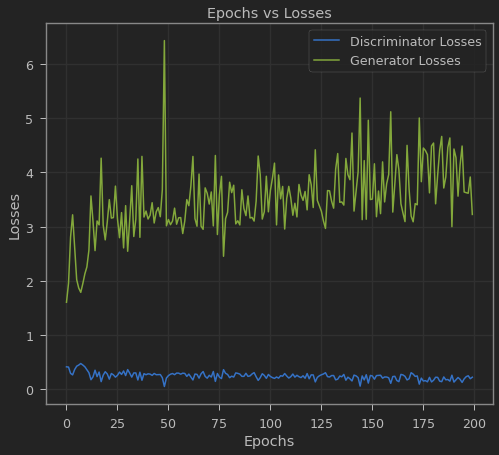

In [ ]:
plt.title("Epochs vs Losses")
plt.plot(d_losses, label="Discriminator Losses")
plt.plot(g_losses, label="Generator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

In [ ]:
!zip images.zip IMAGES/DCGANs_CIFAR/*.*

  adding: IMAGES/DCGANs_CIFAR/gan-101.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-111.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-11.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-121.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-131.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-141.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-151.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-161.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-171.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-181.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-191.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-1.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-21.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-31.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-41.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-51.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-61.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-71.png (deflated 0%)
 

In [109]:
from google.colab import files
files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>